## **Power Plant Regression (Customized + Outliers)**

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

import statsmodels.api as sm

In [40]:
# Create dataframe and test/train splits of the original data w/ outliers.
DATA_PATH = "usina_with_outliers.csv"
df = pd.read_csv(DATA_PATH)

X = df.drop("PE", axis=1)
y = df["PE"]

X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42)

## Question 1: ##
**Model Choice and Justification**: I chose Linear Regression (OLS) because Cook’s Distance was derived specifically for use with OLS models. Ridge and Lasso apply coefficient shrinkage, which can reduce the apparent influence of individual observations. Since the goal of this task is to identify and remove influential outliers, using OLS preserves the full influence structure of the data and makes Cook’s Distance more interpretable.

I chose Statsmodels because it is designed for statistical inference and provides built-in influence diagnostics, including Cook’s Distance. This allows Cook’s Distance to be computed directly from the OLS model without requiring manual implementation, ensuring more correct outlier detection.


In [29]:
X_train_sm = sm.add_constant(X_train)

# Fit OLS for Statsmodel
ols_model = sm.OLS(y_train, X_train_sm).fit()

# Get Cook's Distance
influence = ols_model.get_influence()
cooks_d = influence.cooks_distance[0]

# Create DataFrame for Cook's Distance
cooks_df = pd.DataFrame({
    "CookD": cooks_d
}, index=X_train.index)

# Threshold for removing outliers. 
n = X_train_sm.shape[0]
threshold = 4 / n

# Identify outlier indices
outlier_indices = cooks_df[cooks_df["CookD"] > threshold].index

# Create clean DF 
df_clean = df.drop(index=outlier_indices)

df_clean.to_csv("usina.csv", index=False)


## Question 2: ##

In [30]:
def compute_metrics(model, model_name, alpha=None):
    """Returns MSE, MAE, R^2 information for given model."""
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)
    
    return {
        "Model": f"{model_name}" if alpha is None else f"{model_name} (alpha={alpha})",
        "Train MSE": mean_squared_error(y_train, y_train_pred),
        "Train MAE": mean_absolute_error(y_train, y_train_pred),
        "Train R^2": r2_score(y_train, y_train_pred),
        "Test MSE": mean_squared_error(y_test, y_test_pred),
        "Test MAE": mean_absolute_error(y_test, y_test_pred),
        "Test R^2": r2_score(y_test, y_test_pred)
    }


In [31]:
# OUTLIER DATA
rows = []

# Get linear regression metrics. 
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
rows.append(compute_metrics(lin_reg, "Linear Regression"))

#Get Lasso and Ridge regression metrics per alpha value. 
alphas = [0.01, 0.1, 1, 10, 100]
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    rows.append(compute_metrics(ridge, "Ridge", alpha))

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train, y_train)
    rows.append(compute_metrics(lasso, "Lasso", alpha))

#Print results in DF. 
results = pd.DataFrame(rows)
print("Models trained w/ Outliers")
display(results)

Models trained w/ Outliers


,Model,Train MSE,Train MAE,Train R^2,Test MSE,Test MAE,Test R^2
0,Linear Regression,123.384207,5.198679,0.650171,125.113389,5.052458,0.642574
1,Ridge (alpha=0.01),123.384207,5.198679,0.650171,125.113389,5.052458,0.642574
2,Ridge (alpha=0.1),123.384207,5.198680,0.650171,125.113392,5.052459,0.642574
3,Ridge (alpha=1),123.384207,5.198685,0.650171,125.113421,5.052463,0.642574
4,Ridge (alpha=10),123.384207,5.198737,0.650171,125.113705,5.052513,0.642573
5,Ridge (alpha=100),123.384213,5.199261,0.650171,125.116548,5.053003,0.642565
6,Lasso (alpha=0.01),123.384210,5.198858,0.650171,125.115332,5.052626,0.642568
7,Lasso (alpha=0.1),123.384607,5.201739,0.650169,125.134495,5.055348,0.642514
8,Lasso (alpha=1),123.421151,5.229507,0.650066,125.338356,5.083092,0.641931
9,Lasso (alpha=10),126.141514,5.540418,0.642353,128.902136,5.408803,0.631750


In [32]:
# NON OUTLIER DATA

#Create DF and test/train splits of cleaned data
DATA_PATH = "usina.csv"
df = pd.read_csv(DATA_PATH)

X = df.drop("PE", axis=1)
y = df["PE"]

X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42)

rows = []

# Get linear regression metrics. 
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
rows.append(compute_metrics(lin_reg, "Linear Regression"))

# Get Ridge and Lasso regression metrics for alpha values. 
alphas = [0.01, 0.1, 1, 10, 100]
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    rows.append(compute_metrics(ridge, "Ridge", alpha))

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train, y_train)
    rows.append(compute_metrics(lasso, "Lasso", alpha))

# Display results in DF. 
results = pd.DataFrame(rows)
print("Models trained w/out Outliers")
display(results)

Models trained w/out Outliers


,Model,Train MSE,Train MAE,Train R^2,Test MSE,Test MAE,Test R^2
0,Linear Regression,59.887427,4.069898,0.806996,40.098111,4.013913,0.866504
1,Ridge (alpha=0.01),59.887427,4.069898,0.806996,40.098110,4.013913,0.866504
2,Ridge (alpha=0.1),59.887427,4.069899,0.806996,40.098109,4.013914,0.866504
3,Ridge (alpha=1),59.887427,4.069907,0.806996,40.098097,4.013921,0.866504
4,Ridge (alpha=10),59.887428,4.069987,0.806996,40.097978,4.013988,0.866504
5,Ridge (alpha=100),59.887473,4.070784,0.806995,40.096827,4.014657,0.866508
6,Lasso (alpha=0.01),59.887430,4.069882,0.806996,40.100439,4.013892,0.866496
7,Lasso (alpha=0.1),59.887950,4.072011,0.806994,40.119531,4.015638,0.866433
8,Lasso (alpha=1),59.944088,4.096430,0.806813,40.358763,4.037275,0.865636
9,Lasso (alpha=10),64.728845,4.580677,0.791393,46.589091,4.526738,0.844894


**Discussion:** Outliers do affect both train and test error. When the outliers were removed, both errors decreased and the R^2 improved for both train and test sets.

Both datasets showed similar generalization, but the dataset without outliers performed slightly better. The MAE for the dataset with outliers increased more from train to test, indicating that removing outliers improved generalization.

Comparing models, standard linear regression, Ridge, and Lasso performed similarly overall. Ridge and Lasso did not noticeably outperform linear regression. For Lasso, the coefficients changed slightly for the largest alpha values, but this trend was consistent across both datasets and generally did not improve performance.


## Question 3: ##
**Method choice and Scaling Decision**: For this question, I will use Linear Regression (OLS) with Statsmodels. I am not using Ridge or Lasso because they shrink coefficients, which would make them less interpretable and less reliable for understanding the true effect of each predictor. I chose Statsmodels because it provides built-in p-values, t-statistics, and confidence intervals, allowing me to assess the statistical reliability of each coefficient.

I will not scale either the independent variables (IVs) or the dependent variable (DV). Scaling would change the magnitude of the coefficients, and since I am interested in the coefficients in their original units, scaling would reduce their interpretability and reliability.

In [41]:
# WITH STATSMODEL

X_sm = sm.add_constant(X)

#Fit model
ols_model = sm.OLS(y, X_sm).fit()

#Create results dataframe of coefficients. 
results_df = pd.DataFrame({
    "Coefficient": ols_model.params,
    "t_value": ols_model.tvalues,
    "p_value": ols_model.pvalues
})

results_df = results_df.reindex(results_df["t_value"].abs().sort_values(ascending=False).index)

display(results_df)

,Coefficient,t_value,p_value
AT,-1.152841,-51.515147,0.000000e+00
V,-0.373753,-31.956657,5.272828e-213
AP,0.444891,23.392484,9.877819e-118
const,47.784508,2.447421,1.440612e-02
RH,-0.017546,-2.183688,2.900939e-02


In [42]:
most_reliable = results_df.iloc[0]  # largest absolute t-value
least_reliable = results_df.iloc[-1]  # smallest absolute t-value

print("Most reliable coefficient:")
display(most_reliable)

print("\nLeast reliable coefficient:")
display(least_reliable)


Most reliable coefficient:


Coefficient    -1.152841
t_value       -51.515147
p_value         0.000000
Name: AT, dtype: float64


Least reliable coefficient:


Coefficient   -0.017546
t_value       -2.183688
p_value        0.029009
Name: RH, dtype: float64

The most reliable coefficient was decided by the coefficient with the largest absolute t-value. The smallest t-value showed the least reliable coefficient. The above displays the t values of the each coefficient. 
The most reliable coefficent was the **Ambient Temperature**. The least reliable was the **Relative Humidity**.

## Question 4: ##
**Method choice and scaling decision**: I chose Lasso Regression because it performs automatic feature selection by shrinking some coefficients exactly to zero, making it well-suited for identifying the most and least important features. I used Scikit-learn because it provides efficient implementations of regularized models and integrates naturally with preprocessing tools like feature scaling.

I would scale all independent variables but not the dependent variable. Scaling IVs is necessary because coefficient magnitude is used to assess feature importance, and without scaling, variables measured in larger units would appear artificially more important. Scaling ensures fair comparison and proper application of regularization. Scaling the DV is unnecessary since it does not affect relative feature importance.

In [51]:
#Best Alpha Value Selection
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", LassoCV(
        alphas=np.logspace(-4, 1, 50),
        cv=5,
        random_state=42
    ))
])

pipeline.fit(X_train, y_train)

best_alpha = pipeline.named_steps["lasso"].alpha_
print("Best lambda (alpha):", best_alpha)
print("\n")

#Finding coefficient values scaled. 
lasso = pipeline.named_steps["lasso"]

coefficients = pd.Series(
    lasso.coef_,
    index=X.columns
)

print(f"Coefficients:\n", coefficients)
print("\n")


#Largest and smallest absolute value of coeffficent. 
most_important = coefficients.abs().idxmax() #Largest coefficient value. 

least_important = coefficients.abs().idxmin() #Smallest coefficient value (Lasso shrinks unimportant)

print(f"Most important feature: {most_important} \nLeast Important: {least_important}")

Best lambda (alpha): 0.47148663634573945


Coefficients:
 AT   -8.891647
V    -5.653774
AP    2.425466
RH    0.000000
dtype: float64


Most important feature: AT 
Least Important: RH


**Feature Importance:** The most important feature is **Ambient Temperature** and the least important is **Ambient Pressure**. 

## Question 5: ##

Text(0.5, 1.0, 'Lasso')

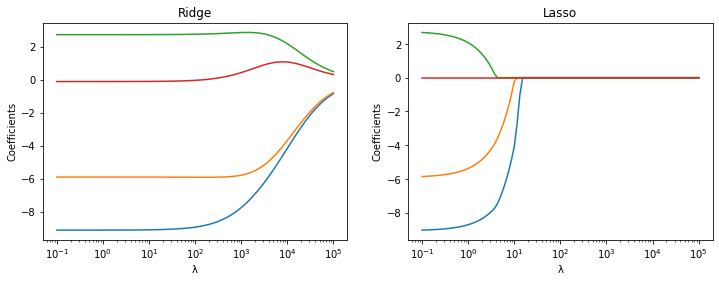

In [52]:
#Create alpha values from 10^-1 to 10^5 (100 values) and coefficient storage. 
alphas = np.logspace(-1, 5, 100)

ridge_coefs = []
lasso_coefs = []

#For each alpha value, fit the model and find coefficients. 
for alpha in alphas:

    ridge = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=alpha))
    ])

    lasso = Pipeline([
        ("scaler", StandardScaler()),
        ("lasso", Lasso(alpha=alpha))
    ])

    ridge.fit(X_train, y_train)
    lasso.fit(X_train, y_train)

    ridge_coefs.append(ridge.named_steps["ridge"].coef_)
    lasso_coefs.append(lasso.named_steps["lasso"].coef_)

ridge_coefs = np.array(ridge_coefs)
lasso_coefs = np.array(lasso_coefs)

#Plot alpha values vs coefficient values. 
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
for j in range(ridge_coefs.shape[1]):
    plt.plot(alphas, ridge_coefs[:, j])
plt.xscale("log")
plt.xlabel("λ")
plt.ylabel("Coefficients")
plt.title("Ridge")

plt.subplot(1, 2, 2)
for j in range(lasso_coefs.shape[1]):
    plt.plot(alphas, lasso_coefs[:, j])
plt.xscale("log")
plt.xlabel("λ")
plt.ylabel("Coefficients")
plt.title("Lasso")


**Discussion:** In Ridge, the coefficients start to slowly shrink and converge towards 0 (but never 0). The coefficient that had a value of 0 even changed and then converged towards 0. In Lasso, the coefficients converge to 0 as the lambda increases, much faster. The coefficient with the smallest absolute value converges faster than the coefficients with larger absolute values, but by a lambda value of 10, all are converging, if not already converged. In Ridge, the convergence seems to be at the same pace regardless of absolute value of the coefficient. 

Ridge is better under multicollinearity because it shrinks correlated variables together without eliminating any (none are ever actually 0). Lasso may select one variable from a group and set the others to zero, which is less stable, since the IV's are all very correlated. 

Lasso is better for feature selection because it has built in feature 'selection' by shrinking those features which are not as important to 0. This introduces sparsity where only the important predictors remain (selected). 